# Create a User Defined Model using astropy.modeling

## Authors
Rocio Kiman, Lia Corrales and Zé Vinícius.

## Learning Goals
* Learn compound models
* Learn costume models
* Use the model to fit and to compare models (needs discussion)

## Keywords
Modeling, Fit, Costume Models, Compound Models 

## Summary
In this tutorial, we will learn how to define a new model in two ways: with a compound model and with a costume model.

### Imports

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.modeling import models, fitting

Let's search for spectrum in the [SDSS database](https://dr12.sdss.org/basicSpectra)
Plate: 1349
MJD: 52797
Fiber: 216
And download the fits file. Save it in the same folder the tutorial is.

## Compound models

In [22]:
spectrum = fits.open('spec-1349-52797-0216.fits')

In [23]:
flux = spectrum[1].data['flux']
lam = 10**(spectrum[1].data['loglam'])

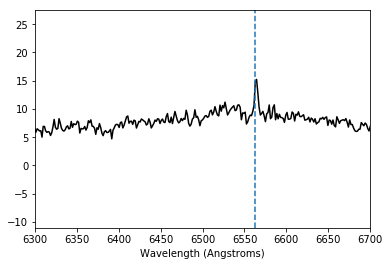

In [29]:
plt.plot(lam, flux, color='k')
plt.xlim(6300,6700)
plt.axvline(x=6563, linestyle='--')
plt.xlabel('Wavelength (Angstroms)')
plt.show()

In [113]:
gg_init = models.Gaussian1D(1, 6563, 10) + models.Polynomial1D(degree=1)   
fitter = fitting.LevMarLSQFitter()
mask = (lam > 6450) * (lam < 6650) 
gg_fit = fitter(gg_init, lam, flux)

Text(0,0.5,'Flux')

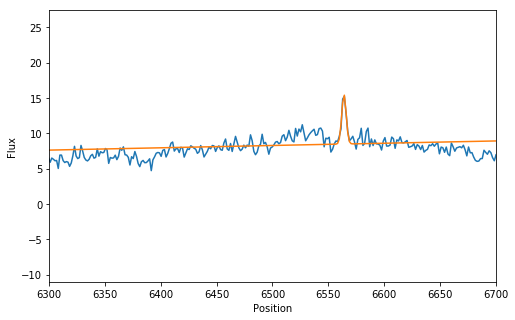

In [116]:
# Plot the data with the best-fit model
plt.figure(figsize=(8,5))
plt.plot(lam, flux)
plt.plot(lam, gg_fit(lam))
plt.xlim(6300,6700)
plt.xlabel('Position')
plt.ylabel('Flux')

In [117]:
print(gg_fit)

Model: CompoundModel43
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] + [1]
Components: 
    [0]: <Gaussian1D(amplitude=1., mean=6563., stddev=10.)>

    [1]: <Polynomial1D(1, c0=0., c1=0.)>
Parameters:
       amplitude_0           mean_0       ...         c1_1        
    ------------------ ------------------ ... --------------------
    7.0208917442781855 6564.1363171493185 ... 0.003239952053005842


## Costume model